# Traffic Analysis using PySpark
This is a personal project to analyze traffic data.

## Install PySpark

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=525352ad7c3560f28eb0bc5796c6fce3409aa7a9c510e6dd87d8ab82c77adebc
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from functools import reduce
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt
import os



## Create Spark Session

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "15g").appName('TrafficAnalysisUsingPySpark').getOrCreate()
print(spark)

In [ ]:
# Load csv to Spark DataFrame
TRAFFIC_DATA = "/content/Dataset-Unicauca-Version2-87Atts.csv"

traffic_df = spark.read.options(header='True',inferSchema='True') \
                    .csv(path=TRAFFIC_DATA)

# Display the schema of DataFrame
traffic_df.printSchema()

root
 |-- Flow.ID: string (nullable = true)
 |-- Source.IP: string (nullable = true)
 |-- Source.Port: integer (nullable = true)
 |-- Destination.IP: string (nullable = true)
 |-- Destination.Port: integer (nullable = true)
 |-- Protocol: integer (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Flow.Duration: integer (nullable = true)
 |-- Total.Fwd.Packets: integer (nullable = true)
 |-- Total.Backward.Packets: integer (nullable = true)
 |-- Total.Length.of.Fwd.Packets: integer (nullable = true)
 |-- Total.Length.of.Bwd.Packets: double (nullable = true)
 |-- Fwd.Packet.Length.Max: integer (nullable = true)
 |-- Fwd.Packet.Length.Min: integer (nullable = true)
 |-- Fwd.Packet.Length.Mean: double (nullable = true)
 |-- Fwd.Packet.Length.Std: double (nullable = true)
 |-- Bwd.Packet.Length.Max: integer (nullable = true)
 |-- Bwd.Packet.Length.Min: integer (nullable = true)
 |-- Bwd.Packet.Length.Mean: double (nullable = true)
 |-- Bwd.Packet.Length.Std: double (nullable = 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Show the first three rows (too many columns!)
# The columns have trailing whitespaces!
# traffic_df.show(3)

## Data Transformation & Exploration

In [ ]:
# Show dataframe columns

current_columns = traffic_df.columns

new_columns = list(map(lambda item : item.replace(" ","_").replace(".","_").upper().strip(),current_columns))

final_df = reduce(lambda data, idx: data.withColumnRenamed(current_columns[idx], new_columns[idx]), range(len(current_columns)), traffic_df)

final_df.printSchema()

root
 |-- FLOW_ID: string (nullable = true)
 |-- SOURCE_IP: string (nullable = true)
 |-- SOURCE_PORT: integer (nullable = true)
 |-- DESTINATION_IP: string (nullable = true)
 |-- DESTINATION_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- TIMESTAMP: string (nullable = true)
 |-- FLOW_DURATION: integer (nullable = true)
 |-- TOTAL_FWD_PACKETS: integer (nullable = true)
 |-- TOTAL_BACKWARD_PACKETS: integer (nullable = true)
 |-- TOTAL_LENGTH_OF_FWD_PACKETS: integer (nullable = true)
 |-- TOTAL_LENGTH_OF_BWD_PACKETS: double (nullable = true)
 |-- FWD_PACKET_LENGTH_MAX: integer (nullable = true)
 |-- FWD_PACKET_LENGTH_MIN: integer (nullable = true)
 |-- FWD_PACKET_LENGTH_MEAN: double (nullable = true)
 |-- FWD_PACKET_LENGTH_STD: double (nullable = true)
 |-- BWD_PACKET_LENGTH_MAX: integer (nullable = true)
 |-- BWD_PACKET_LENGTH_MIN: integer (nullable = true)
 |-- BWD_PACKET_LENGTH_MEAN: double (nullable = true)
 |-- BWD_PACKET_LENGTH_STD: double (nullable = 

In [ ]:
# Count rows of df
final_df.count()

229055

In [ ]:
# Display newly modified columns
final_df.columns

['FLOW_ID',
 'SOURCE_IP',
 'SOURCE_PORT',
 'DESTINATION_IP',
 'DESTINATION_PORT',
 'PROTOCOL',
 'TIMESTAMP',
 'FLOW_DURATION',
 'TOTAL_FWD_PACKETS',
 'TOTAL_BACKWARD_PACKETS',
 'TOTAL_LENGTH_OF_FWD_PACKETS',
 'TOTAL_LENGTH_OF_BWD_PACKETS',
 'FWD_PACKET_LENGTH_MAX',
 'FWD_PACKET_LENGTH_MIN',
 'FWD_PACKET_LENGTH_MEAN',
 'FWD_PACKET_LENGTH_STD',
 'BWD_PACKET_LENGTH_MAX',
 'BWD_PACKET_LENGTH_MIN',
 'BWD_PACKET_LENGTH_MEAN',
 'BWD_PACKET_LENGTH_STD',
 'FLOW_BYTES_S',
 'FLOW_PACKETS_S',
 'FLOW_IAT_MEAN',
 'FLOW_IAT_STD',
 'FLOW_IAT_MAX',
 'FLOW_IAT_MIN',
 'FWD_IAT_TOTAL',
 'FWD_IAT_MEAN',
 'FWD_IAT_STD',
 'FWD_IAT_MAX',
 'FWD_IAT_MIN',
 'BWD_IAT_TOTAL',
 'BWD_IAT_MEAN',
 'BWD_IAT_STD',
 'BWD_IAT_MAX',
 'BWD_IAT_MIN',
 'FWD_PSH_FLAGS',
 'BWD_PSH_FLAGS',
 'FWD_URG_FLAGS',
 'BWD_URG_FLAGS',
 'FWD_HEADER_LENGTH',
 'BWD_HEADER_LENGTH',
 'FWD_PACKETS_S',
 'BWD_PACKETS_S',
 'MIN_PACKET_LENGTH',
 'MAX_PACKET_LENGTH',
 'PACKET_LENGTH_MEAN',
 'PACKET_LENGTH_STD',
 'PACKET_LENGTH_VARIANCE',
 'FIN_FLAG_

In [ ]:
# Create a subtable by selecting some columns

sub_df = final_df.select('FLOW_ID',
 'SOURCE_IP',
 'SOURCE_PORT',
 'DESTINATION_IP',
 'DESTINATION_PORT',
 'PROTOCOL',
 'TIMESTAMP',
 'FLOW_DURATION',
 'TOTAL_FWD_PACKETS',
 'TOTAL_BACKWARD_PACKETS',
 'TOTAL_LENGTH_OF_FWD_PACKETS',
 'TOTAL_LENGTH_OF_BWD_PACKETS',
 'FLOW_BYTES_S',
 'FLOW_PACKETS_S',
 'AVERAGE_PACKET_SIZE',
 'LABEL',
 'PROTOCOLNAME')
sub_df.show(10)

+--------------------+-------------+-----------+--------------+----------------+--------+------------------+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------+------------+
|             FLOW_ID|    SOURCE_IP|SOURCE_PORT|DESTINATION_IP|DESTINATION_PORT|PROTOCOL|         TIMESTAMP|FLOW_DURATION|TOTAL_FWD_PACKETS|TOTAL_BACKWARD_PACKETS|TOTAL_LENGTH_OF_FWD_PACKETS|TOTAL_LENGTH_OF_BWD_PACKETS|    FLOW_BYTES_S|  FLOW_PACKETS_S|AVERAGE_PACKET_SIZE| LABEL|PROTOCOLNAME|
+--------------------+-------------+-----------+--------------+----------------+--------+------------------+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------+------------+
|172.19.1.46-10.20...|  172.19.1.46|      52422|    10.200.7.7|            3128|       6|26/04/201711:11:17|        45

In [ ]:
# Check out what protocol name we have
sub_df.groupBy("PROTOCOLNAME").count().show()

+-------------+-----+
| PROTOCOLNAME|count|
+-------------+-----+
|      TWITTER|  982|
|          DNS|   95|
|          MSN|  799|
| HTTP_CONNECT| 9929|
|HTTP_DOWNLOAD|   51|
|         MQTT|   11|
|    INSTAGRAM|   84|
|   OPENSIGNAL|    9|
|     WHATSAPP|  147|
|    MICROSOFT| 3310|
| MS_ONE_DRIVE|  157|
| APPLE_ITUNES|   35|
|   OFFICE_365|  141|
|CONTENT_FLASH|  430|
|        GMAIL| 2129|
|        APPLE|  304|
|        SKYPE| 1720|
|          TOR|   15|
|        YAHOO| 1348|
|     FACEBOOK| 1285|
+-------------+-----+
only showing top 20 rows



In [ ]:
# Calculate count, mean, stddev, min and max for FLOW_DURATION
sub_df.select('FLOW_DURATION').describe().show()

+-------+--------------------+
|summary|       FLOW_DURATION|
+-------+--------------------+
|  count|              229055|
|   mean|2.0839168872288316E7|
| stddev|3.7375859022279605E7|
|    min|                   1|
|    max|           119999999|
+-------+--------------------+



In [ ]:
# Check for any NaN values
sub_df.select([count(when(isnan(c), c)).alias(c) for c in sub_df.columns]).show()

+-------+---------+-----------+--------------+----------------+--------+---------+-------------+-----------------+----------------------+---------------------------+---------------------------+------------+--------------+-------------------+-----+------------+
|FLOW_ID|SOURCE_IP|SOURCE_PORT|DESTINATION_IP|DESTINATION_PORT|PROTOCOL|TIMESTAMP|FLOW_DURATION|TOTAL_FWD_PACKETS|TOTAL_BACKWARD_PACKETS|TOTAL_LENGTH_OF_FWD_PACKETS|TOTAL_LENGTH_OF_BWD_PACKETS|FLOW_BYTES_S|FLOW_PACKETS_S|AVERAGE_PACKET_SIZE|LABEL|PROTOCOLNAME|
+-------+---------+-----------+--------------+----------------+--------+---------+-------------+-----------------+----------------------+---------------------------+---------------------------+------------+--------------+-------------------+-----+------------+
|      0|        0|          0|             0|               0|       0|        0|            0|                0|                     0|                          0|                          0|           0|           

In [ ]:
# Show distinct values
sub_df.select('PROTOCOLNAME').distinct().collect()

[Row(PROTOCOLNAME='TWITTER'),
 Row(PROTOCOLNAME='DNS'),
 Row(PROTOCOLNAME='MSN'),
 Row(PROTOCOLNAME='HTTP_CONNECT'),
 Row(PROTOCOLNAME='HTTP_DOWNLOAD'),
 Row(PROTOCOLNAME='MQTT'),
 Row(PROTOCOLNAME='INSTAGRAM'),
 Row(PROTOCOLNAME='OPENSIGNAL'),
 Row(PROTOCOLNAME='WHATSAPP'),
 Row(PROTOCOLNAME='MICROSOFT'),
 Row(PROTOCOLNAME='MS_ONE_DRIVE'),
 Row(PROTOCOLNAME='APPLE_ITUNES'),
 Row(PROTOCOLNAME='OFFICE_365'),
 Row(PROTOCOLNAME='CONTENT_FLASH'),
 Row(PROTOCOLNAME='GMAIL'),
 Row(PROTOCOLNAME='APPLE'),
 Row(PROTOCOLNAME='SKYPE'),
 Row(PROTOCOLNAME='TOR'),
 Row(PROTOCOLNAME='YAHOO'),
 Row(PROTOCOLNAME='FACEBOOK'),
 Row(PROTOCOLNAME='WIKIPEDIA'),
 Row(PROTOCOLNAME='SSL_NO_CERT'),
 Row(PROTOCOLNAME='APPLE_ICLOUD'),
 Row(PROTOCOLNAME='NTP'),
 Row(PROTOCOLNAME='UBUNTUONE'),
 Row(PROTOCOLNAME='WINDOWS_UPDATE'),
 Row(PROTOCOLNAME='IP_ICMP'),
 Row(PROTOCOLNAME='CLOUDFLARE'),
 Row(PROTOCOLNAME='EBAY'),
 Row(PROTOCOLNAME='YOUTUBE'),
 Row(PROTOCOLNAME='HTTP_PROXY'),
 Row(PROTOCOLNAME='MSSQL'),
 Row(PR

In [ ]:
socmed = ['TWITTER','INSTAGRAM','FACEBOOK']

records = sub_df.filter(sub_df.PROTOCOLNAME.isin(socmed))

records.show(5)

+--------------------+-------------+-----------+--------------+----------------+--------+------------------+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------+------------+
|             FLOW_ID|    SOURCE_IP|SOURCE_PORT|DESTINATION_IP|DESTINATION_PORT|PROTOCOL|         TIMESTAMP|FLOW_DURATION|TOTAL_FWD_PACKETS|TOTAL_BACKWARD_PACKETS|TOTAL_LENGTH_OF_FWD_PACKETS|TOTAL_LENGTH_OF_BWD_PACKETS|    FLOW_BYTES_S|  FLOW_PACKETS_S|AVERAGE_PACKET_SIZE| LABEL|PROTOCOLNAME|
+--------------------+-------------+-----------+--------------+----------------+--------+------------------+-------------+-----------------+----------------------+---------------------------+---------------------------+----------------+----------------+-------------------+------+------------+
|157.240.0.22-10.2...| 10.200.7.217|      53809|  157.240.0.22|             443|       6|26/04/201711:11:18|          

## Pandas Conversion & Exploration

In [ ]:
records_df = records.toPandas()

In [ ]:
records_df

,FLOW_ID,SOURCE_IP,SOURCE_PORT,DESTINATION_IP,DESTINATION_PORT,PROTOCOL,TIMESTAMP,FLOW_DURATION,TOTAL_FWD_PACKETS,TOTAL_BACKWARD_PACKETS,TOTAL_LENGTH_OF_FWD_PACKETS,TOTAL_LENGTH_OF_BWD_PACKETS,FLOW_BYTES_S,FLOW_PACKETS_S,AVERAGE_PACKET_SIZE,LABEL,PROTOCOLNAME
0,157.240.0.22-10.200.7.217-443-53809-6,10.200.7.217,53809,157.240.0.22,443,6,26/04/201711:11:18,1,2,0,0,0.0,0.000000e+00,2.000000e+06,0.000000,BENIGN,FACEBOOK
1,192.168.151.4-10.200.7.5-51444-3128-6,192.168.151.4,51444,10.200.7.5,3128,6,26/04/201711:11:19,14276,5,17,233,8900.0,6.397450e+05,1.541048e+03,415.136364,BENIGN,FACEBOOK
2,192.168.151.4-10.200.7.5-51443-3128-6,192.168.151.4,51443,10.200.7.5,3128,6,26/04/201711:11:19,15072,5,16,233,8900.0,6.059581e+05,1.393312e+03,434.904762,BENIGN,FACEBOOK
3,192.168.151.4-10.200.7.5-51445-3128-6,192.168.151.4,51445,10.200.7.5,3128,6,26/04/201711:11:20,3703,5,16,233,8900.0,2.466379e+06,5.671078e+03,434.904762,BENIGN,FACEBOOK
4,157.240.0.22-10.200.7.217-443-53809-6,10.200.7.217,53809,157.240.0.22,443,6,26/04/201711:11:22,1,2,0,0,0.0,0.000000e+00,2.000000e+06,0.000000,BENIGN,FACEBOOK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,10.200.7.217-104.244.46.231-45099-443-6,104.244.46.231,443,10.200.7.217,45099,6,26/04/201703:11:07,10525450,13,8,13990,554.0,1.381794e+03,1.995164e+00,761.523810,BENIGN,TWITTER
2347,10.200.7.217-104.244.46.231-45099-443-6,104.244.46.231,443,10.200.7.217,45099,6,26/04/201703:11:17,584,1,1,0,0.0,0.000000e+00,3.424658e+03,0.000000,BENIGN,TWITTER
2348,157.240.0.22-10.200.7.194-443-37153-6,157.240.0.22,443,10.200.7.194,37153,6,26/04/201703:04:26,2735343,2,3,0,208.0,7.604165e+01,1.827924e+00,41.600000,BENIGN,FACEBOOK
2349,157.240.0.22-10.200.7.195-443-38465-6,157.240.0.22,443,10.200.7.195,38465,6,26/04/201703:09:25,30000936,2,2,0,212.0,7.066446e+00,1.333292e-01,53.000000,BENIGN,FACEBOOK


In [ ]:
records_df['TIMESTAMP'] = pd.to_datetime(records_df['TIMESTAMP'],format= '%d/%m/%Y%H:%M:%S' )

In [ ]:
records_df.head()

,FLOW_ID,SOURCE_IP,SOURCE_PORT,DESTINATION_IP,DESTINATION_PORT,PROTOCOL,TIMESTAMP,FLOW_DURATION,TOTAL_FWD_PACKETS,TOTAL_BACKWARD_PACKETS,TOTAL_LENGTH_OF_FWD_PACKETS,TOTAL_LENGTH_OF_BWD_PACKETS,FLOW_BYTES_S,FLOW_PACKETS_S,AVERAGE_PACKET_SIZE,LABEL,PROTOCOLNAME
0,157.240.0.22-10.200.7.217-443-53809-6,10.200.7.217,53809,157.240.0.22,443,6,2017-04-26 11:11:18,1,2,0,0,0.0,0.000000e+00,2.000000e+06,0.000000,BENIGN,FACEBOOK
1,192.168.151.4-10.200.7.5-51444-3128-6,192.168.151.4,51444,10.200.7.5,3128,6,2017-04-26 11:11:19,14276,5,17,233,8900.0,6.397450e+05,1.541048e+03,415.136364,BENIGN,FACEBOOK
2,192.168.151.4-10.200.7.5-51443-3128-6,192.168.151.4,51443,10.200.7.5,3128,6,2017-04-26 11:11:19,15072,5,16,233,8900.0,6.059581e+05,1.393312e+03,434.904762,BENIGN,FACEBOOK
3,192.168.151.4-10.200.7.5-51445-3128-6,192.168.151.4,51445,10.200.7.5,3128,6,2017-04-26 11:11:20,3703,5,16,233,8900.0,2.466379e+06,5.671078e+03,434.904762,BENIGN,FACEBOOK
4,157.240.0.22-10.200.7.217-443-53809-6,10.200.7.217,53809,157.240.0.22,443,6,2017-04-26 11:11:22,1,2,0,0,0.0,0.000000e+00,2.000000e+06,0.000000,BENIGN,FACEBOOK


## Bar Count Plot

<Axes: xlabel='PROTOCOLNAME'>

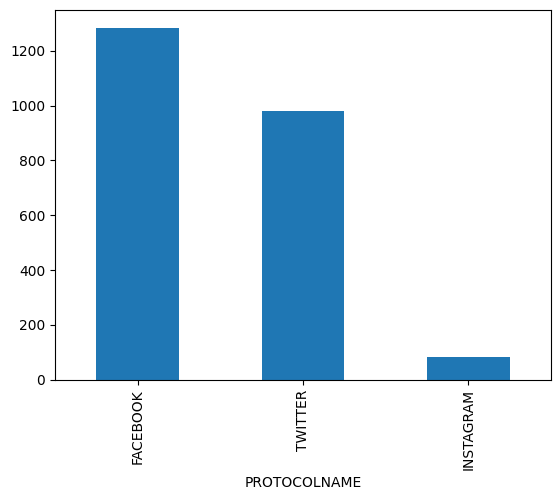

In [ ]:
# Create a bar plot in pandas
records_df["PROTOCOLNAME"].value_counts().plot.bar()

<Axes: xlabel='PROTOCOLNAME', ylabel='count'>

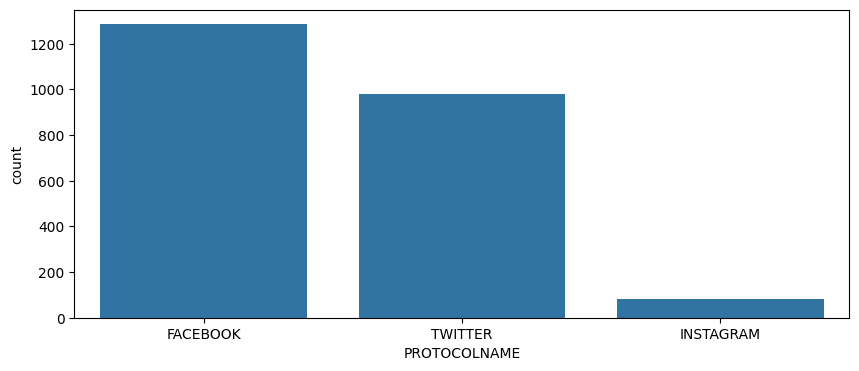

In [ ]:
# Use seaborn to plot the same graph above
import seaborn as sns
plt.figure(figsize=(10,4))
sns.countplot(x = 'PROTOCOLNAME', data = records_df)

## Network Graph Plot
The graph generated will be too complex if you include multiple PROTOCOLNAME.

### NetworkX

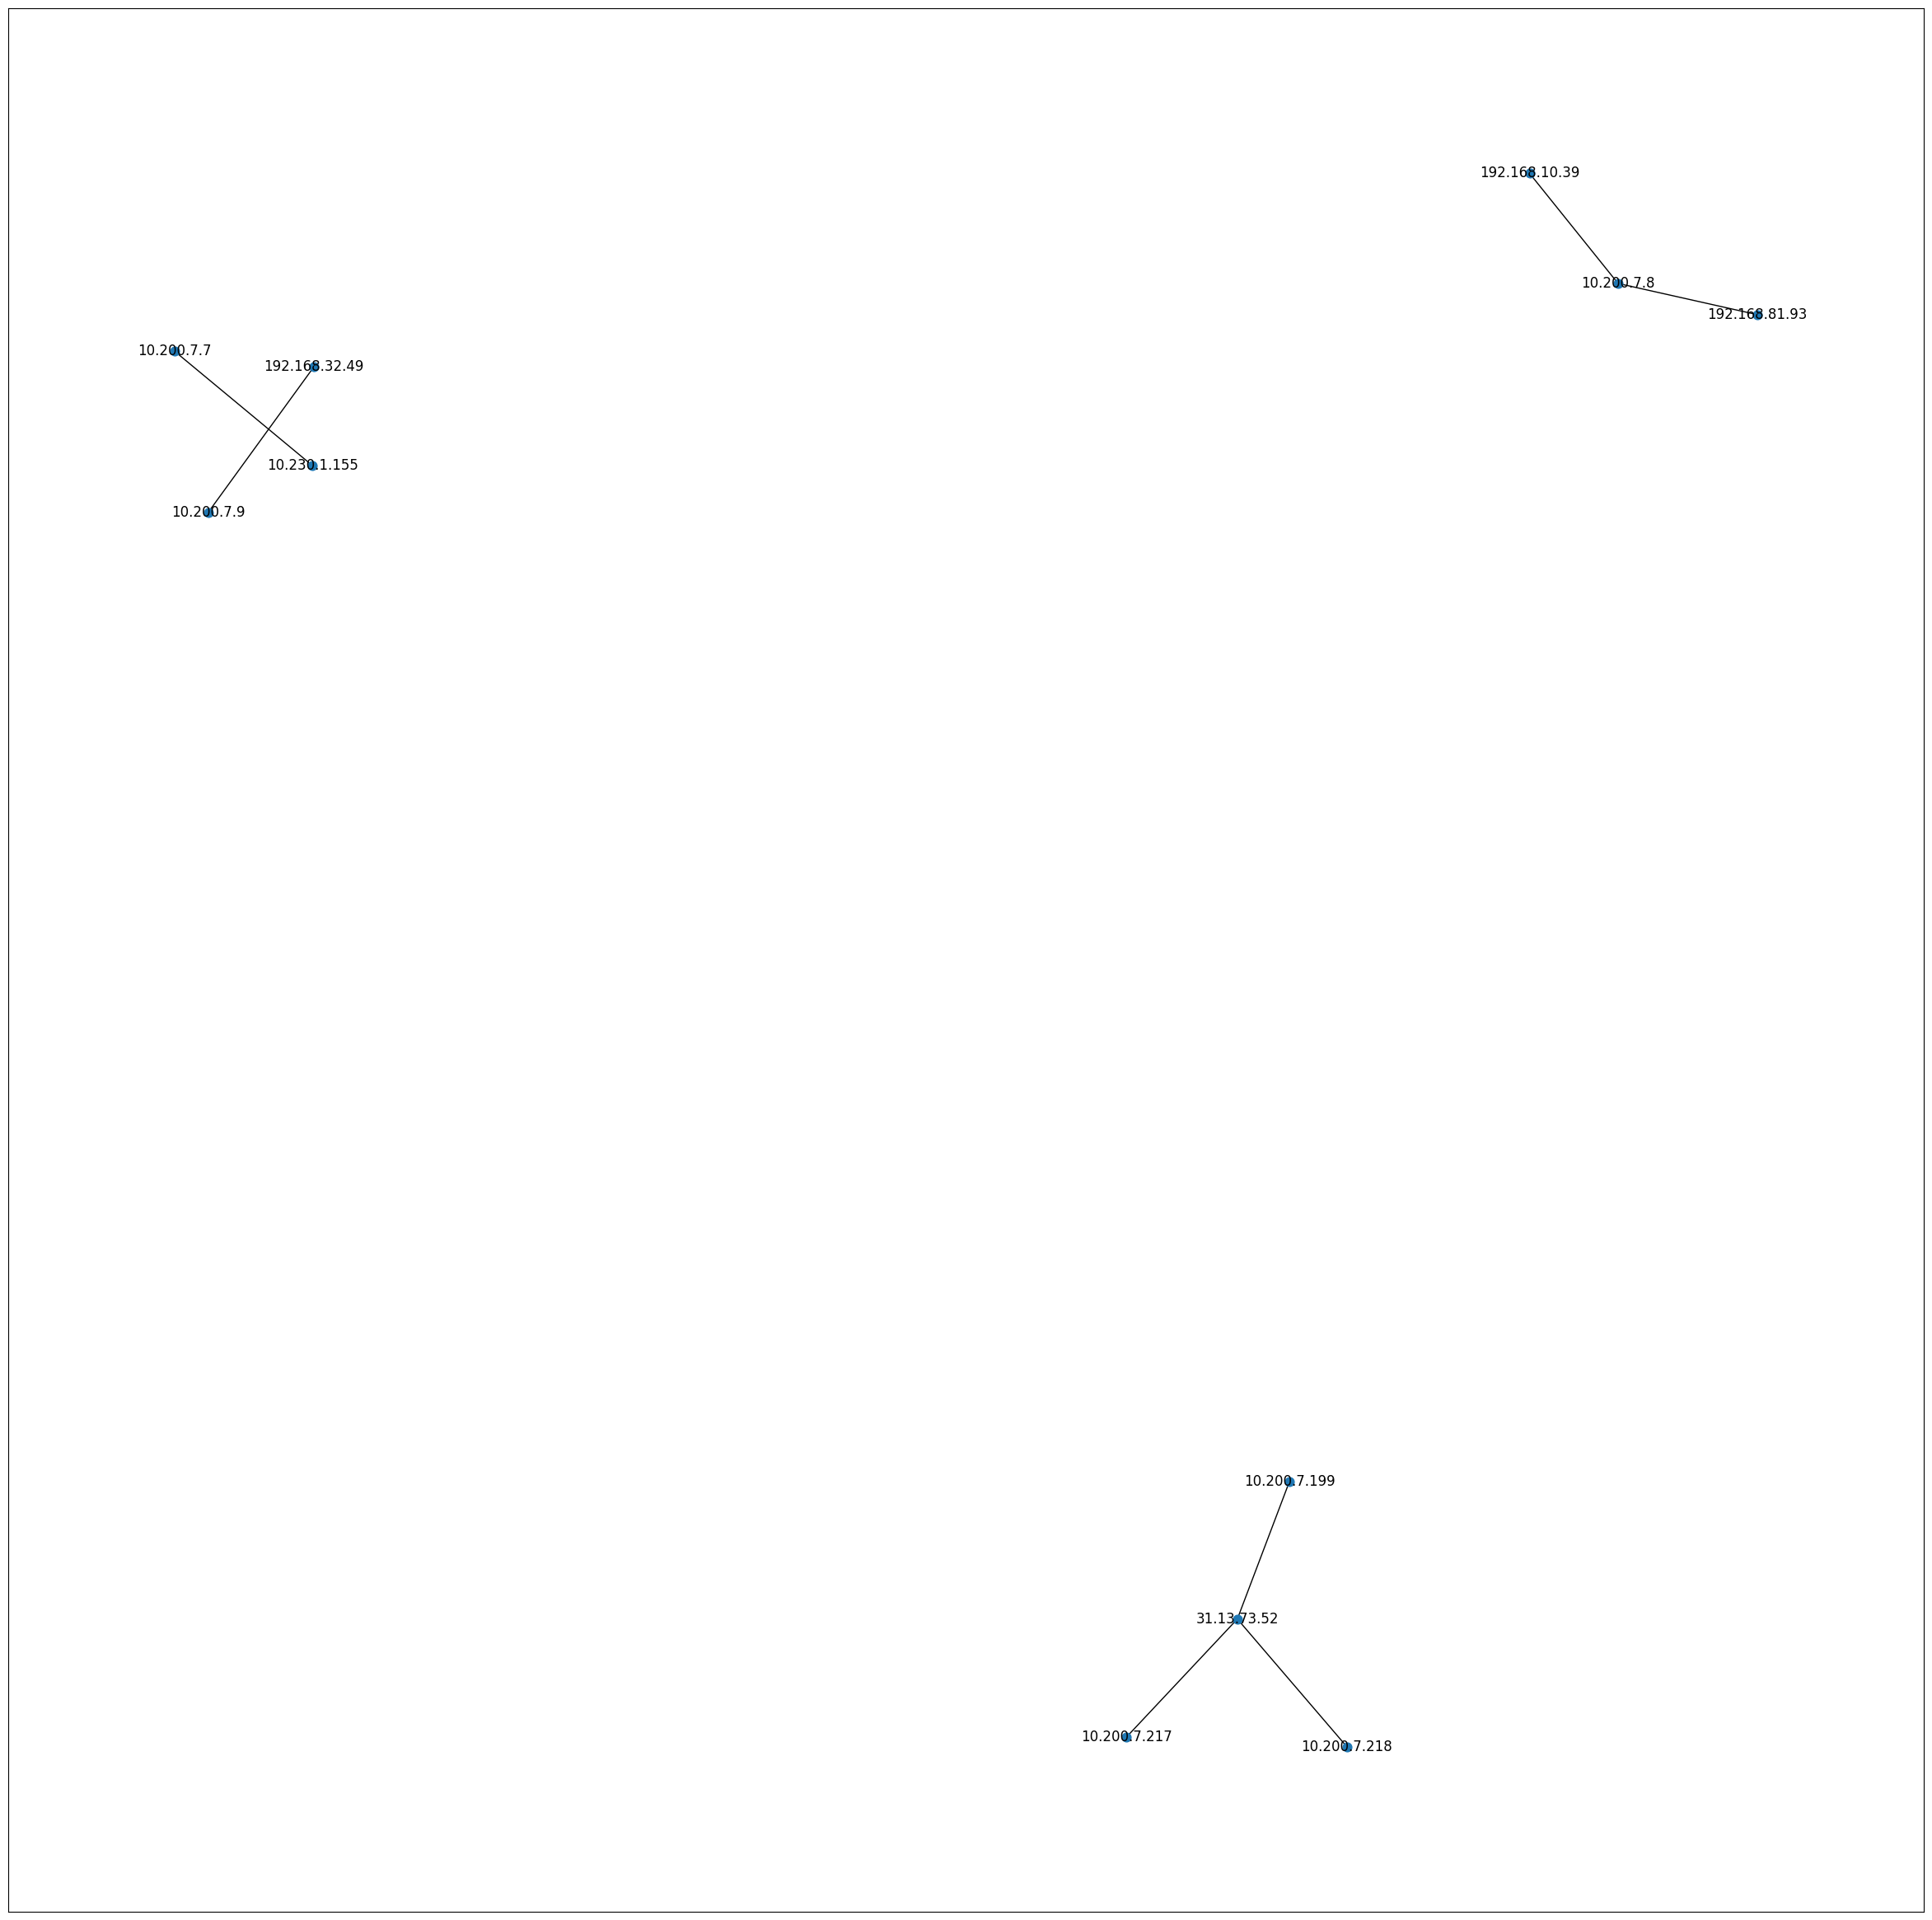

In [ ]:
import networkx as nx

G = nx.Graph()

G = nx.from_pandas_edgelist(records_df[records_df['PROTOCOLNAME']=='INSTAGRAM'], 'SOURCE_IP', 'DESTINATION_IP')
# G = nx.from_pandas_edgelist(records_df[records_df, 'SOURCE_IP', 'DESTINATION_IP')

plt.figure(figsize=(30, 30))
nx.draw_networkx(G, with_labels=True,node_size=60,font_size=12)

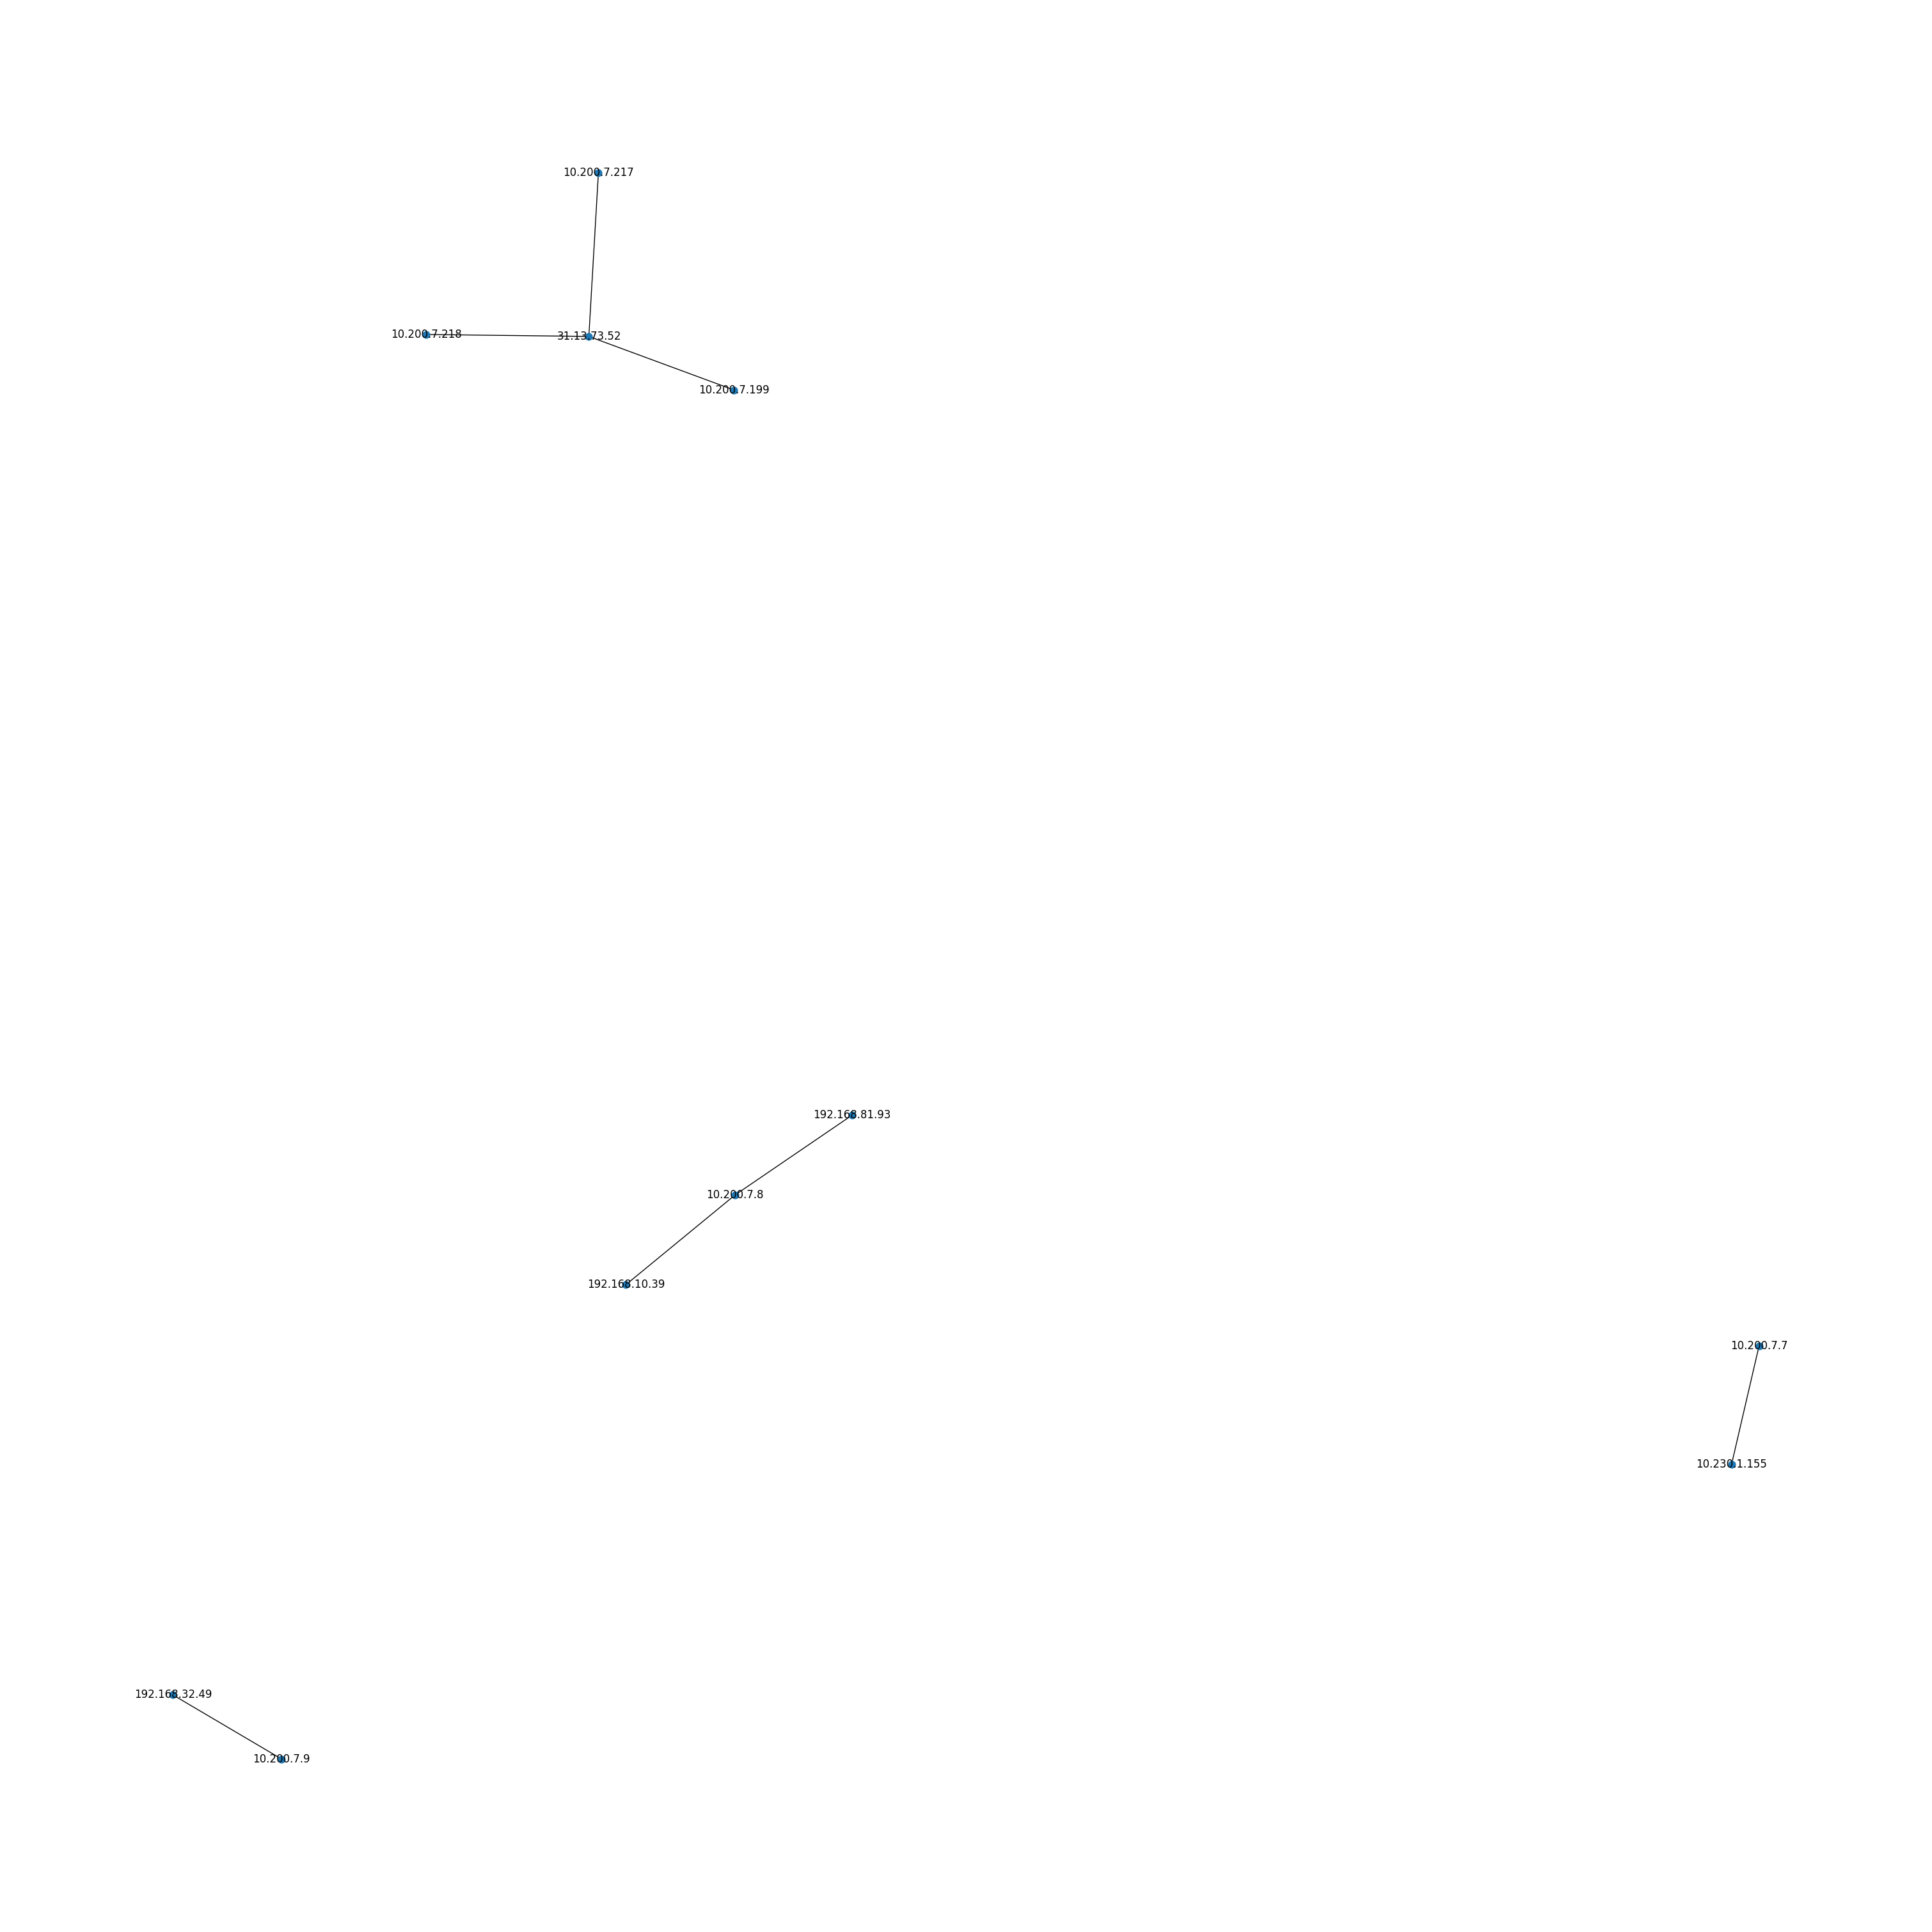

In [ ]:
# nx.draw_shell(G, with_labels=True,node_size=60,font_size=12)
plt.figure(figsize=(30, 30))
nx.draw_spring(G, with_labels=True,node_size=60,font_size=12)

In [ ]:
# Print out network edges
[e for e in G.edges]

[('10.200.7.199', '31.13.73.52'),
 ('31.13.73.52', '10.200.7.217'),
 ('31.13.73.52', '10.200.7.218'),
 ('10.230.1.155', '10.200.7.7'),
 ('192.168.32.49', '10.200.7.9'),
 ('192.168.81.93', '10.200.7.8'),
 ('10.200.7.8', '192.168.10.39')]

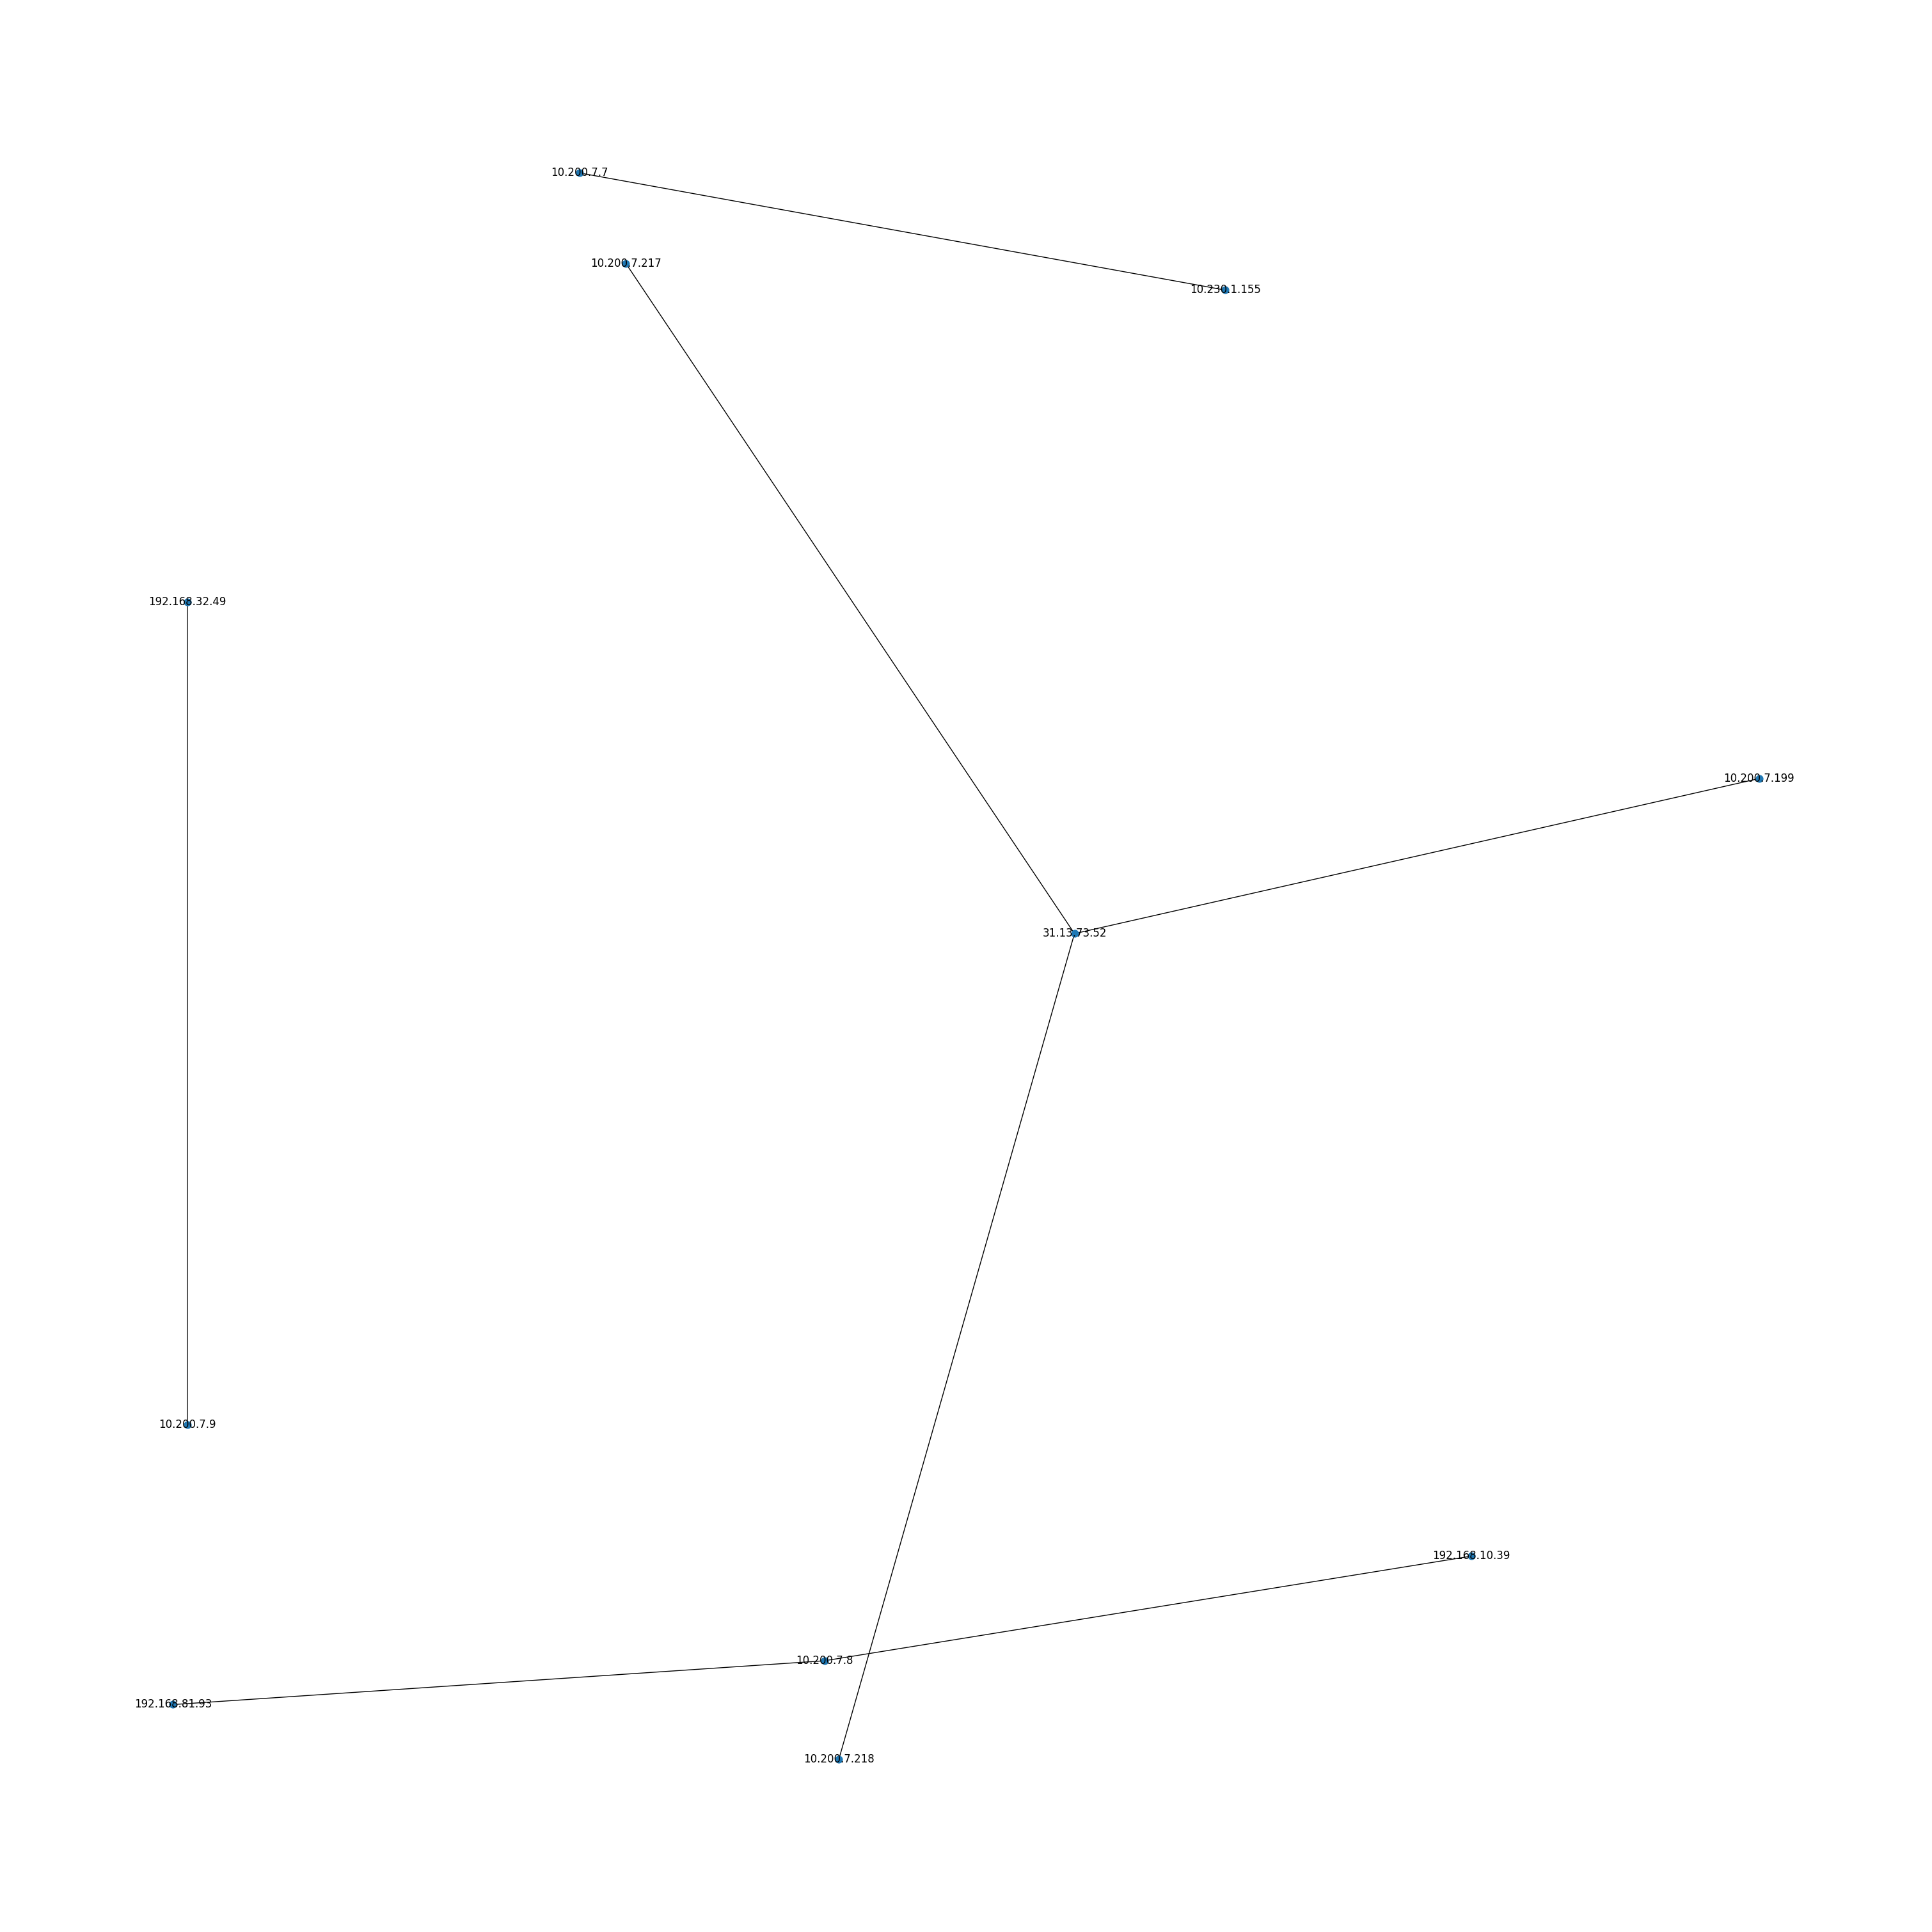

In [ ]:
plt.figure(figsize=(30, 30))
nx.draw_kamada_kawai(G, with_labels=True,node_size=60,font_size=12)

## Time Series Plot

In [ ]:
import plotly.express as px

fig = px.line(records_df[records_df['PROTOCOLNAME']=='INSTAGRAM'], x='TIMESTAMP', y="AVERAGE_PACKET_SIZE",
             title="Average Packet Size vs Time")
fig.show()

## Support Vector Machine (SVM) Classifier

In [ ]:
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
# Label encode protocol name
encoder = LabelEncoder().fit(records_df['PROTOCOLNAME'])
records_df['PROTOCOLNAME'] = encoder.fit_transform(records_df['PROTOCOLNAME'])
records_df['PROTOCOLNAME']

,PROTOCOLNAME
0,0
1,0
2,0
3,0
4,0
...,...
2346,2
2347,2
2348,0
2349,0


In [ ]:
X = records_df.drop(columns = ['FLOW_ID',
 'SOURCE_IP',
 'SOURCE_PORT',
 'DESTINATION_IP',
 'DESTINATION_PORT',
 'PROTOCOL',
 'TIMESTAMP',
 'LABEL',
 'PROTOCOLNAME'])
Y = records_df['PROTOCOLNAME']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

imputer = SimpleImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [ ]:
model = SVC()
model.fit(X_train,Y_train)

SVC()

In [ ]:
pred = model.predict(X_test)
explained_variance_score(pred,Y_test)

-1.773835808912084

In [ ]:
accuracy_score(pred,Y_test)

0.6242038216560509